In [1]:
import os
import sys

import numpy as np
import pandas as pd

import pickle

import matplotlib.pyplot as plt

import seaborn as sns 
from sklearn.decomposition import PCA

# Reading + Organizing the DATA: 

In [2]:
# The data comes from 
# os.listdir("../../project_data/")

['GSE131512_metaData.xlsx',
 'GSE131512_normalTPM.txt',
 'validation_bc_meta.xlsx',
 'pnas_patient_info.csv',
 'Homo_sapiens.GRCh38.111.gtf',
 'validation_normal_meta.xlsx',
 'gene_result_1.txt',
 'GSE131512_cancerTPM.txt',
 'gene_result.txt']

In [2]:
normal_df = pd.read_csv("../../project_data/GSE131512_normalTPM.txt", delimiter = '\t')
cancer_df = pd.read_csv("../../project_data/GSE131512_cancerTPM.txt", delimiter = '\t')
normal_df.shape, cancer_df.shape

((60675, 32), (60675, 96))

## Sample Metadata

In [3]:
# Metadata from the GEO page
filepath = "../../project_data/GSE131512_metaData.xlsx"
metadata = pd.read_excel(filepath)

# metadata for validation datasets from the github (not sure which samples it is referencing)
filepath = "../../project_data/validation_bc_meta.xlsx"
validation_bc_meta = pd.read_excel(filepath)
filepath = "../../project_data/validation_normal_meta.xlsx"
validation_normal_meta = pd.read_excel(filepath)

# additional metadata about cancer subtypes for the 96 cancer patients
filepath = "../../project_data/pnas_patient_info.csv"
patient_info = pd.read_csv(filepath)

In [4]:
# checking the shapes of the metadata to see if they fit expectation
# metadata.shape,patient_info.shape, validation_normal_meta.shape, validation_bc_meta.shape

In [5]:
# Adding a chemo duration, and time from chemo end to recurrence fields
dt_end = pd.to_datetime(patient_info['datechemoend'], format="%d/%m/%Y")
dt_start = pd.to_datetime(patient_info['datechemostart'], format="%d/%m/%Y")
dt_recurrence = pd.to_datetime(patient_info['daterecurrence'], format="%d/%m/%Y")
patient_info['chemo_duration'] = (dt_end - dt_start).dt.days
patient_info['recurrence_time'] = (dt_recurrence - dt_end).dt.days

# Joining the two metadatas together)
metadata = pd.concat([metadata, 
                      patient_info[['cancertype', 'cancerstage_cat', 'chemo_duration', 'recurrence_time',  'chemo', 'recurStatus']]], 
                     axis=1, join='outer')
# setting the recurrence time for those that don't have recurrence to nan
metadata.loc[metadata.recurStatus == 'N', 'recurrence_time'] = np.nan
metadata.set_index("Sample name", inplace=True)
# writing the result out in a csv
metadata.to_csv('../data/metadata.csv')

# To make sure there are no nan's in the data
metadata.replace(np.nan, 0, inplace=True)

## Gene Metadata

In [6]:
gene_ids = normal_df.index.values

Using the GTF data to assign gene names 

In [7]:
with open("../../project_data/Homo_sapiens.GRCh38.111.gtf", 'r') as f: 
    gtf = f.readlines() 

gtf = [x for x in gtf if not x.startswith('#')]
gtf = [x for x in gtf if 'gene_id "' in x and 'gene_name "' in x]
gtf = list(map(lambda x: (x.split('gene_id "')[1].split('"')[0], x.split('gene_name "')[1].split('"')[0]), gtf))
gtf = dict(list(set(gtf)))

Defining the gene names based on gene ids

In [8]:
def catch(func, handle=lambda e: e, *args, **kwargs):
    try: 
        return func(*args, **kwargs)
    except Exception as e: 
        return "" 

In [9]:
gene_names = [catch(lambda : gtf[x]) for x in gene_ids]
gene_meta = pd.DataFrame({"gene_id": gene_ids, "gene_name" : gene_names}).set_index("gene_id")

gene_meta.shape

(60675, 1)

### Gene Terms

In [10]:
df_terms_bc = pd.read_csv("../data/ncbi_bc_associations.txt", delimiter='\t')

# only looking for hunan genes
df_terms_bc = df_terms_bc.drop(df_terms_bc[df_terms_bc.Org_name != "Homo sapiens"].index)
# Getting the gene names
bc_genes = df_terms_bc.Symbol.values
# adding the gene names to the meta data dataframe
gene_meta['is_bc'] = gene_meta.gene_name.isin(bc_genes)

In [11]:
with open("../data/prior_association.txt", 'r') as f:
    prior_genes = f.readlines()

prior_genes = prior_genes[0].split(", ")
prior_genes[-1] = prior_genes[-1].split(',')[0]
prior_genes = np.asarray(prior_genes)
gene_meta['is_prior'] = gene_meta.gene_name.isin(prior_genes)

In [12]:
# generating the subset genes based on the association genes
# gene_subset = gene_meta[gene_meta.is_bc] # for ncbi assoc. genes (5531)
gene_subset = gene_meta[gene_meta.is_prior] # for prior genes (paper - 551)

## Expression Data

In [93]:
# Overall Expression 
# gene_expression = pd.concat([cancer_df, normal_df], axis=1).T
# samp_meta = metadata

# If I want to not include the non-cancer samples 
gene_expression = pd.concat([cancer_df], axis=1).T
samp_meta = metadata[:96]

# Subset Expression 
gene_expression_subset = gene_expression.T[gene_expression.columns.isin(gene_subset.index)].T
# gene_expression_subset = zscore(gene_expression_subset, axis=0)

In [96]:
np.where((gene_expression_subset.sum() == 0))

(array([], dtype=int64),)

In [95]:
gene_expression_subset = gene_expression_subset.drop(gene_expression_subset.columns[np.where((gene_expression_subset.sum() == 0))[0]], axis=1)

# PyWGCNA

## Run their pipeline

In [52]:
import PyWGCNA as wgc

Pre-processing...
	Detecting genes and samples with too many missing values...
	Done pre-processing..

Run WGCNA...
pickSoftThreshold: calculating connectivity for given powers...
will use block size  549
    Power  SFT.R.sq     slope truncated R.sq   mean(k)  median(k)     max(k)
0       1  0.077173 -1.115996       0.982084  28.91668  28.746898   48.96162
1       2  0.657423 -2.766918       0.839977  5.041425   4.737846  14.469906
2       3  0.388326 -4.575305       0.291221  1.240451    0.99747   8.654171
3       4  0.385884 -4.602575        0.30887   0.40103   0.240192   5.735058
4       5   0.27545 -3.233026       0.068494  0.162068   0.064152   4.045345
5       6  0.300466 -2.926719       0.112389   0.07799   0.017893   2.979762
6       7  0.276316 -2.915677        0.06996  0.042748   0.005549   2.266758
7       8  0.299863 -2.787129       0.103639  0.025772   0.001777   1.768108
8       9  0.277856 -2.769839       0.087766  0.016669   0.000608   1.407155
9      10  0.286203 -2.69

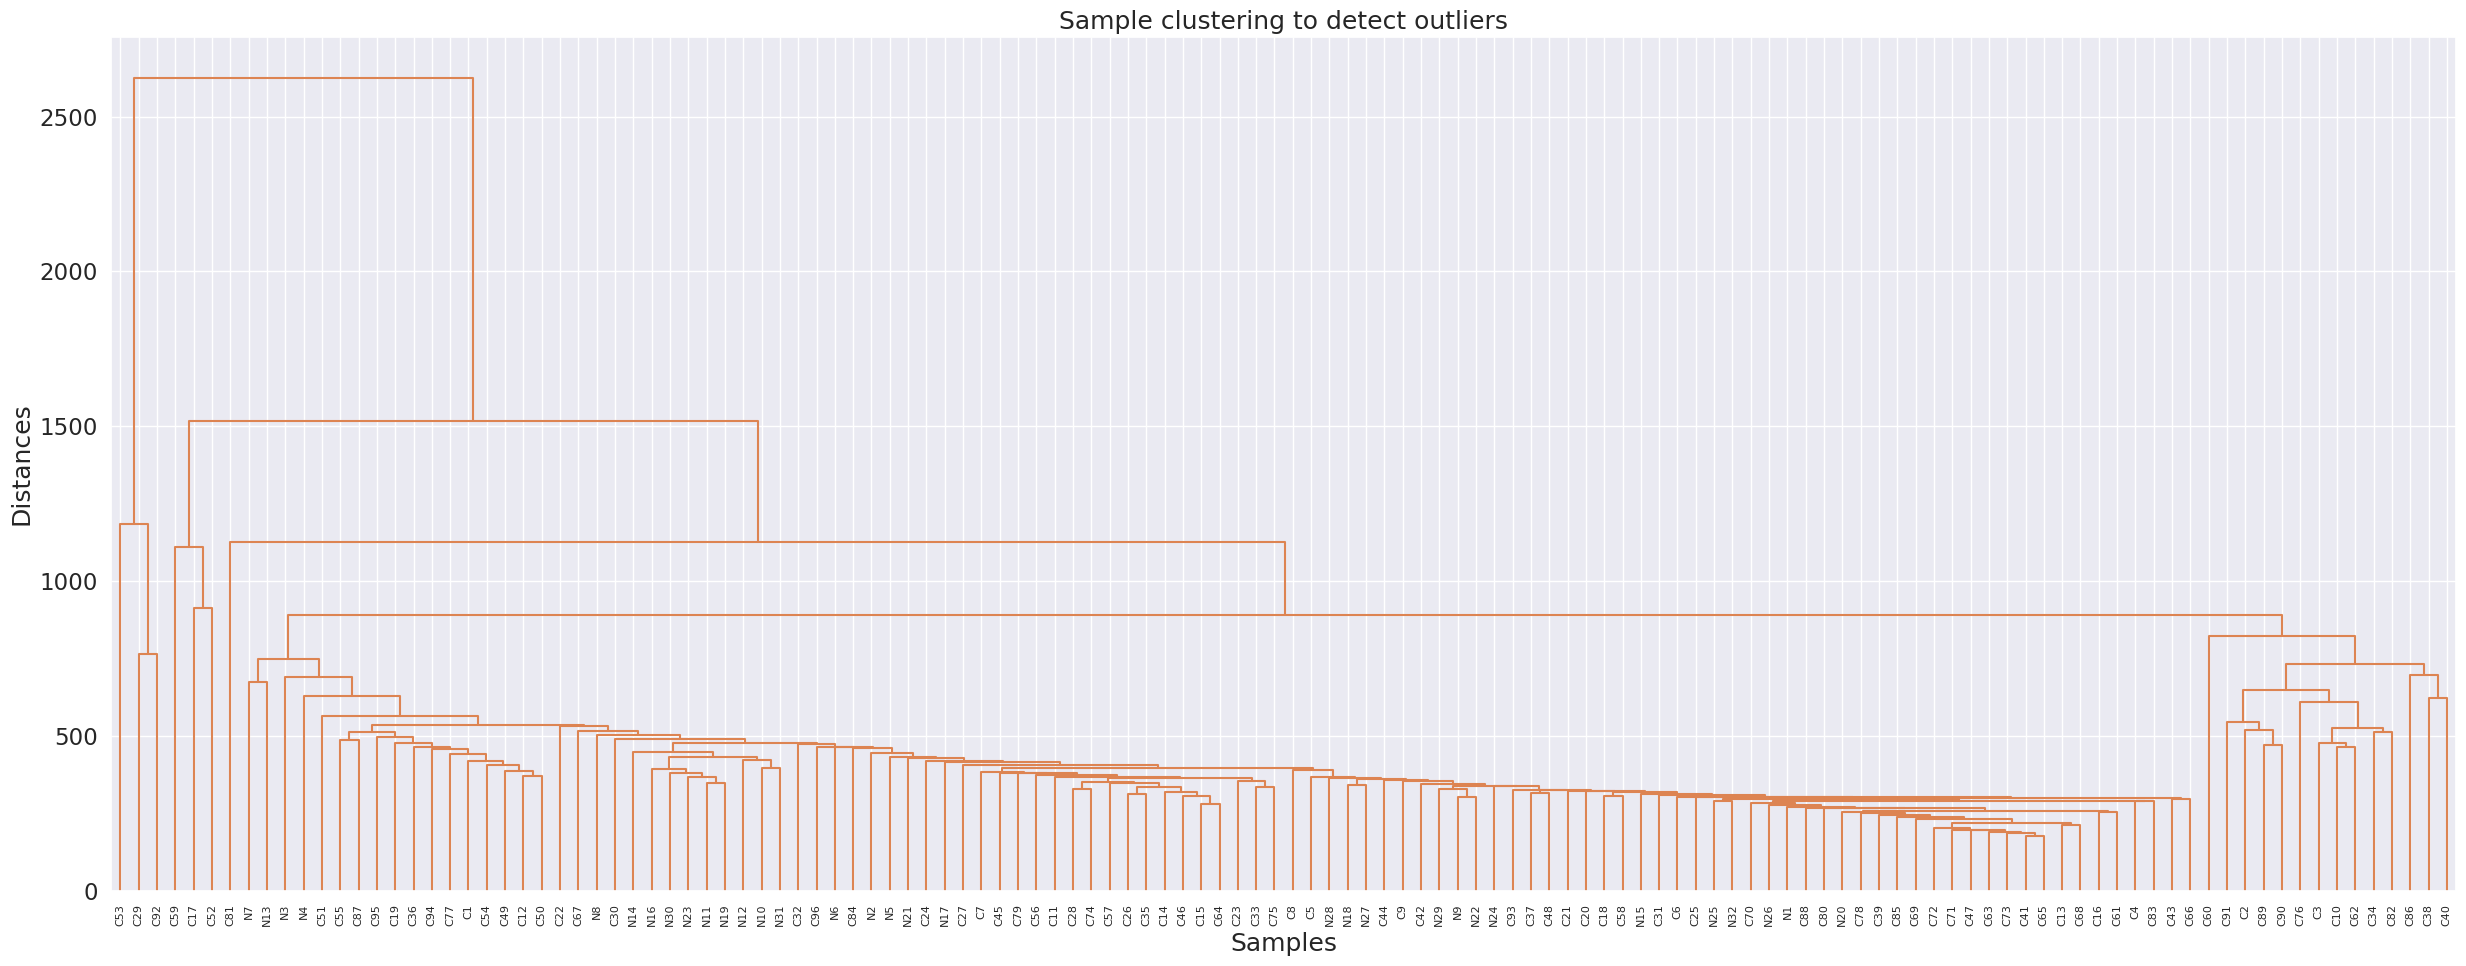

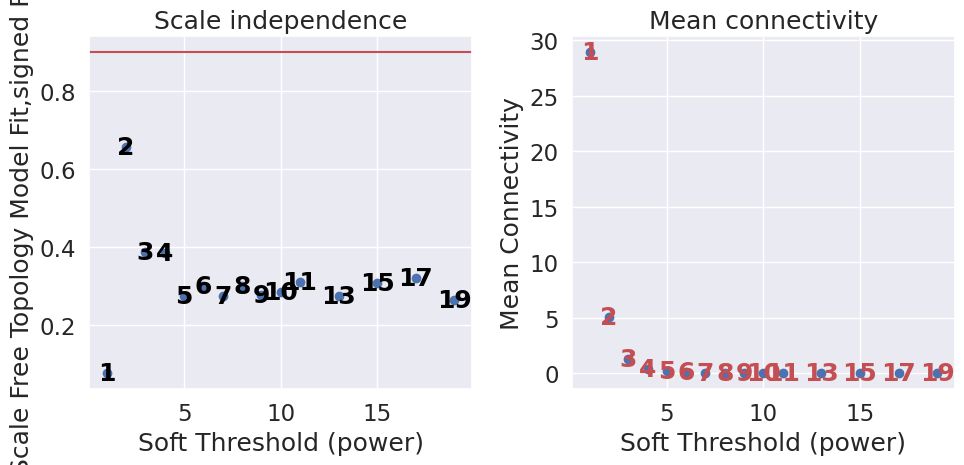

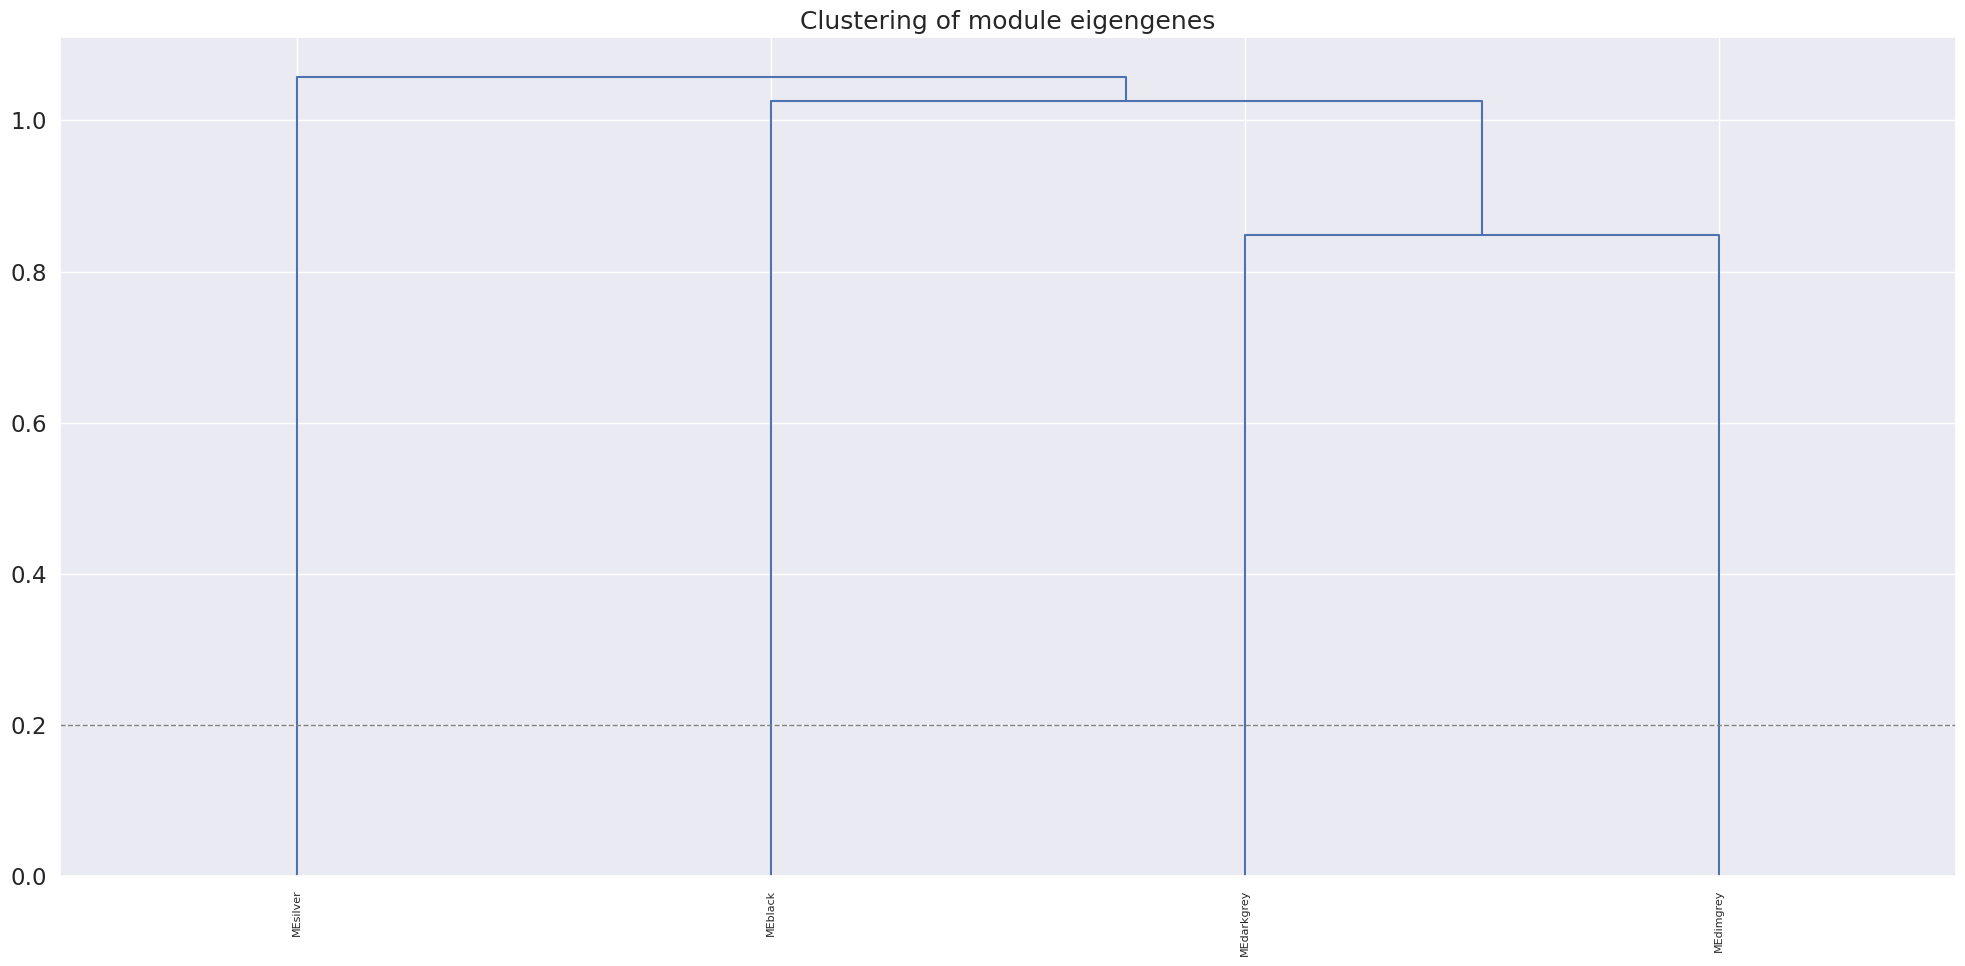

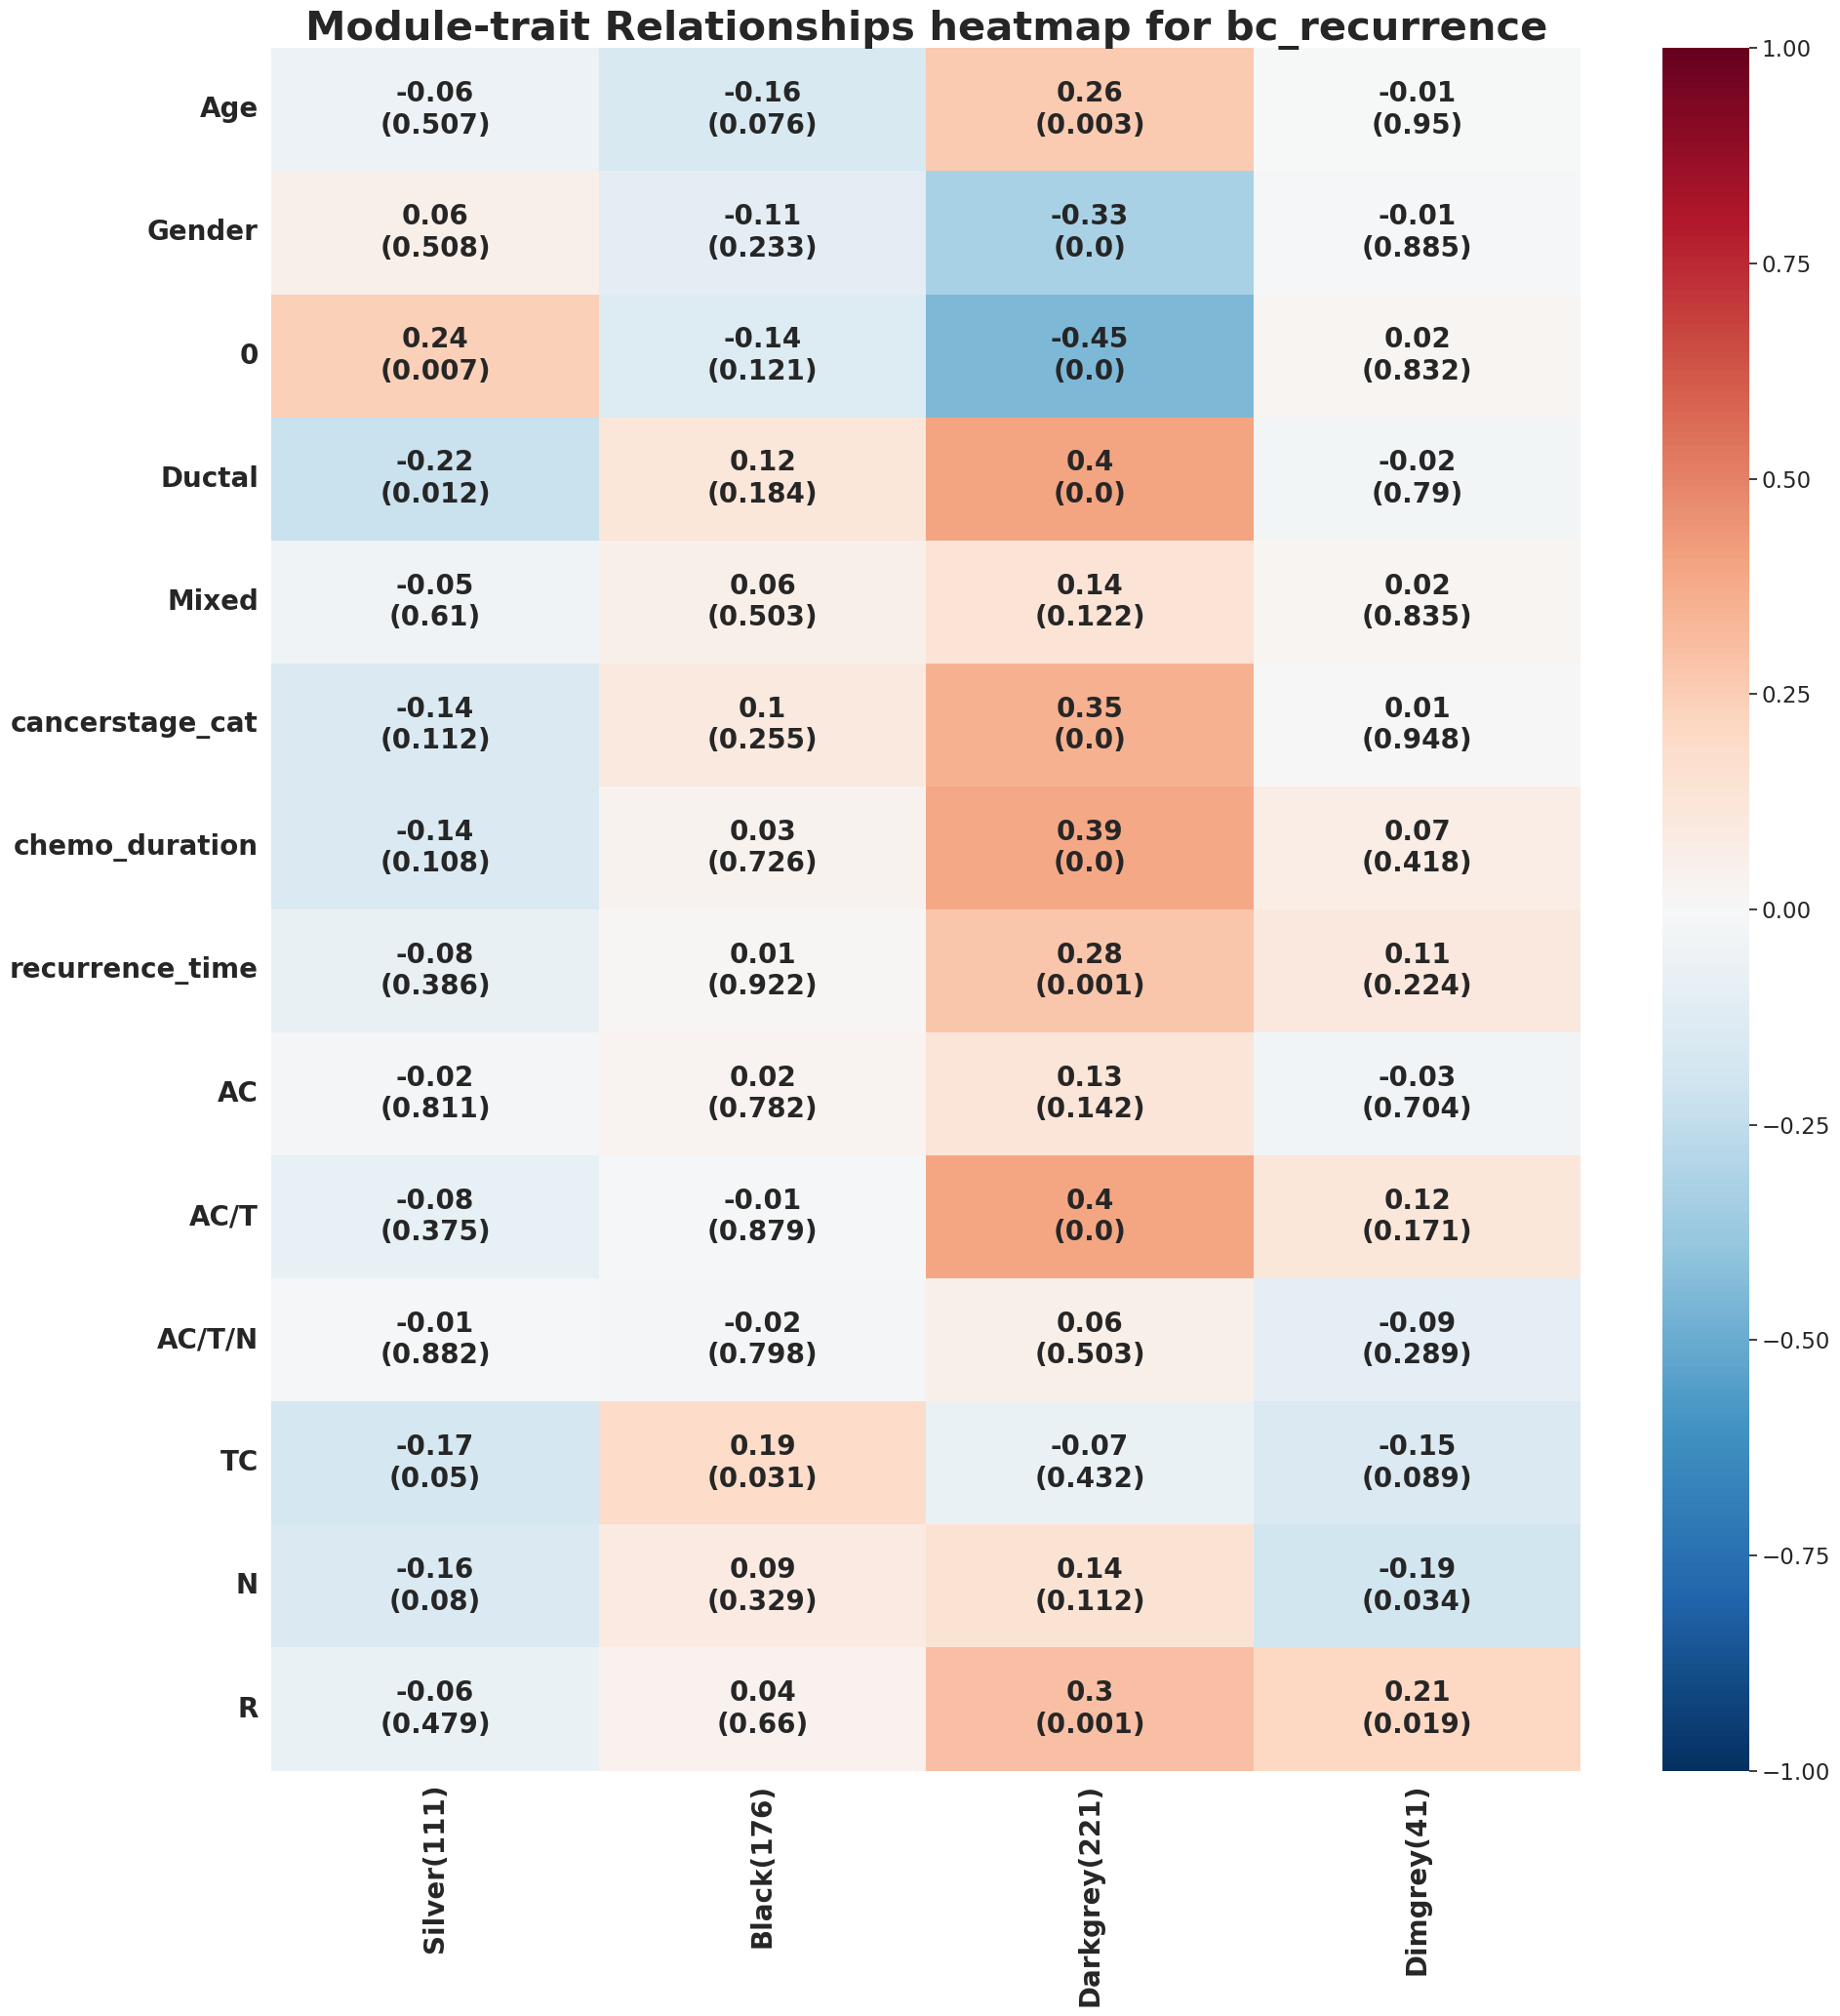

In [55]:
bc_obj = wgc.wgcna.WGCNA(name = "bc_recurrence", geneExp = gene_expression_subset, geneInfo=gene_subset, sampleInfo=samp_meta)
bc_obj.preprocess()
bc_obj.findModules()
bc_obj.analyseWGCNA()

## Get the modules 

In [56]:
%%capture

# Storing the cluster genes in a list
module_names = [c[2:] for c in bc_obj.datME.columns]
num_modules = len(module_names)

modules = []
for m in module_names[:num_modules]: 
    modules.append(bc_obj.top_n_hub_genes(moduleName=m, n=1000))

In [57]:
# Transforming the clsuter into a dictionary to store more information on reach cluster
cluster_info = {"cluster_id" : [],
                "gene_ids" : [],
                "gene_names" : [],
                "exp_var" : [],
                "eigen_vects" : []}
for i, df in enumerate(modules): 
    # display(df)
    cluster_info['cluster_id'].append(i) 
    cluster_info['gene_names'].append(df.gene_name.values)
    cluster_info['gene_ids'].append(df.index.values)
    # break

## Get the Module Eigenvectors

In [43]:
from scipy.stats import zscore

In [58]:
# To calculate and store the eigen vectors for each cluster

# Iterating over each cluster 
for row in cluster_info['cluster_id']:
    # getting the expression matrix for that cluster
    ids = cluster_info['cluster_id'][row]
    gene_ids = cluster_info['gene_ids'][row]
    sub_gene_expr = gene_expression[gene_ids]
    sub_gene_expr = zscore(sub_gene_expr.T).T
    
    # performing PCA on the cluster expression matrix
    pca = PCA()
    pca.fit(sub_gene_expr)
    # adding the eigen vectors to the dictionary
    cluster_info['exp_var'].append(pca.explained_variance_ratio_[:5])
    cluster_info['eigen_vects'].append(pca.components_[:5])

In [59]:
# To calculate the transformation matrix to turn the data into its cluster projections 
transformation = []

# Iterating over each cluster 
for row in cluster_info['cluster_id']:
    gene_ids = cluster_info['gene_ids'][row]
    for i in range(5): 
        eigen = cluster_info['eigen_vects'][row][i]
        e_vect = []
        
        for g in gene_expression_subset.columns: 
            if g in gene_ids: 
                idx = np.where(gene_ids == g)[0]
                e_vect.append(eigen[idx[0]])            
            else:
                e_vect.append(0)
        # print(e_vect)
        e_vect = np.asarray(e_vect)
        transformation.append(e_vect)

np_tran = np.asarray(transformation)
np_tran.shape

(20, 551)

## Transform dataset

In [60]:
labels = [f"C{i+1}_P{j+1}" for i in range(num_modules) for j in range(5)]
dataset = zscore(gene_expression_subset, axis=1).values @ np_tran.T
df_dataset = pd.DataFrame(dataset, columns = labels, index = gene_expression_subset.index)

### Write to Pickle

In [63]:
with open("../data/prior_transformed_dataset.pandas", 'wb') as f: 
    pickle.dump(df_dataset, f)

## Validate clusters with PCA

In [61]:
df_dataset

C1_P1      C1_P2     C1_P3     C1_P4     C1_P5     C2_P1     C2_P2  \
C1   15.384707   2.999278 -0.465011 -0.215533 -0.299751 -0.215681  0.556810   
C2   19.552225   2.239666 -3.261700 -1.801539 -1.453615 -0.132358 -0.369888   
C3   17.672178   2.007924 -2.939309  0.281303  0.422424  4.683716 -1.766170   
C4    8.642104  -1.379556 -4.057315  1.904199  0.368110 -4.499129 -2.723830   
C5    4.025661  -1.844188 -3.151874 -0.367553 -0.111619 -3.295737 -1.796215   
..         ...        ...       ...       ...       ...       ...       ...   
N28  -2.619411   0.476027 -2.711137  1.853083 -4.371660  4.239767 -5.623976   
N29  -2.827485   5.925630 -4.638501 -1.595345  0.035397  0.362146 -0.126174   
N30  -5.647417   9.814696 -4.958401  1.203189  1.183640 -1.350606 -0.983872   
N31  -4.270789  11.951536 -4.128814 -1.789175 -1.608413  2.832163 -1.506208   
N32  -4.371180   5.366809 -1.980740  1.740857 -4.319600 -0.026880 -3.058441   

        C2_P3     C2_P4     C2_P5     C3_P1     C3_P2     C3_P3     C3_P4  \
C1  -2.738113  4.161474 -4.638163 -1.195951  0.390672  0.414120  0.550098   
C2  -1.372723  1.845797 -0.995817 -1.030988 -0.115095 -0.608018  0.155602   
C3  -2.195780  3.104058  0.289537 -0.580198 -0.726341 -0.634500  0.006656   
C4   3.502143  3.676724 -2.432296 -0.164893 -0.447443 -1.121196  0.496917   
C5  -0.700095  3.489038  0.005500 -2.363950  2.999760 -0.762921  0.368549   
..        ...       ...       ...       ...       ...       ...       ...   
N28  4.292616  5.820194 -2.820968 -2.098917 -0.119917  0.341503 -1.067118   
N29 -1.091833  3.123873 -4.748687 -1.062402 -0.526471 -0.249470  1.440534   
N30  1.754526  0.236323 -1.430198 -1.888103  3.360132  0.539443  0.348084   
N31 -1.343508 -0.883514  0.794723 -0.821888 -0.020150 -0.490044 -0.706568   
N32  0.562394 -1.002409 -0.113204  1.425320 -1.398827 -0.636989  0.672353   

        C3_P5     C4_P1     C4_P2     C4_P3     C4_P4     C4_P5  
C1   1.406844 -0.205180  0.779112  0.735757 -1.260690  1.006746  
C2   0.176395  0.734202  0.546983 -0.703699 -0.133047  0.395967  
C3  -0.123169  2.366258  1.079790  0.651035 -1.501380  1.889479  
C4   2.766982  2.088902  2.274678 -1.514866 -0.478655 -1.197587  
C5   0.451896  2.168035  0.962932  0.809956 -0.275190  1.235803  
..        ...       ...       ...       ...       ...       ...  
N28  0.325039 -0.434938  5.327063  2.602626 -1.175166  0.027629  
N29 -2.385057  0.168192 -0.841205  0.703009 -0.986846  0.638309  
N30  0.582453  1.271222  0.073372  0.057860 -2.687714  1.748423  
N31 -1.734461  0.948263  1.181270  0.513192 -0.065659  0.031516  
N32  1.752769  1.090280  0.875344  0.327986 -2.463457 -2.744730  

[128 rows x 20 columns]

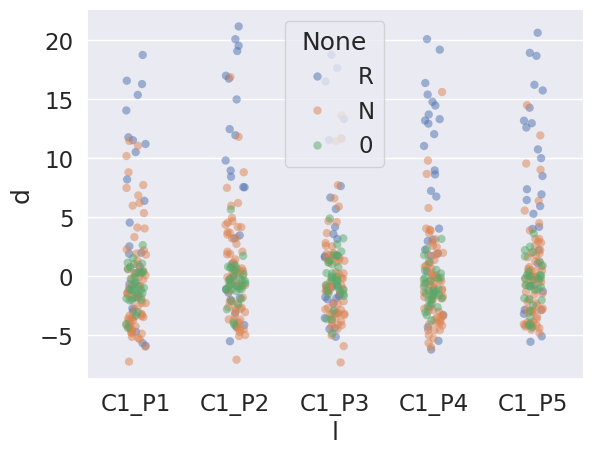

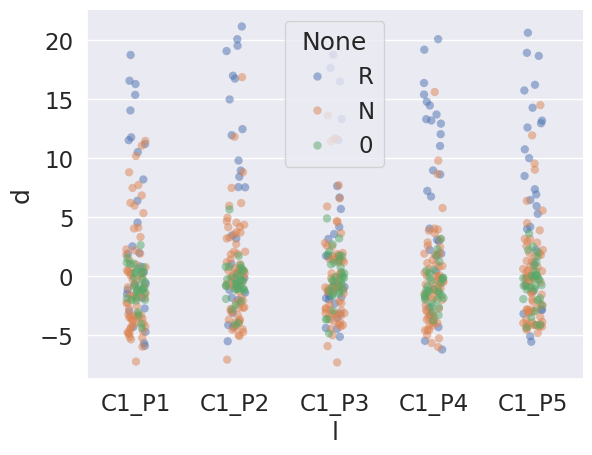

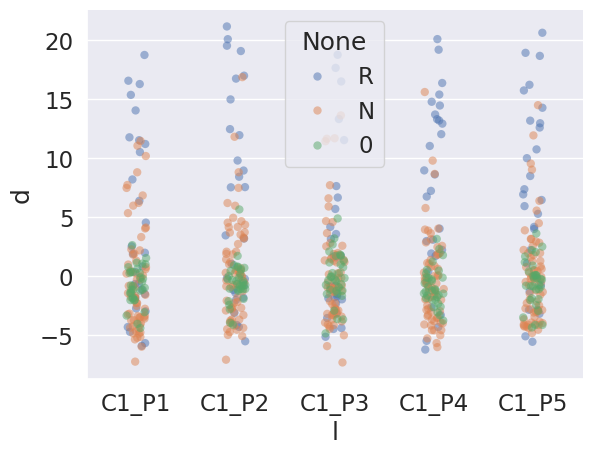

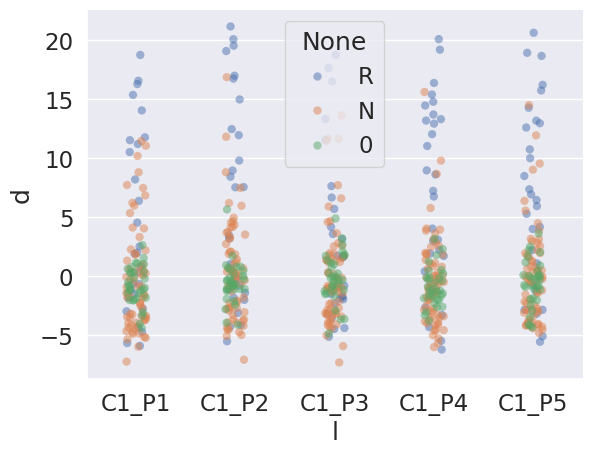

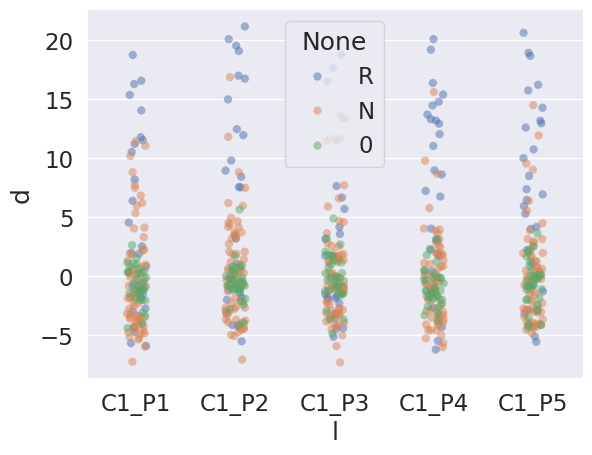

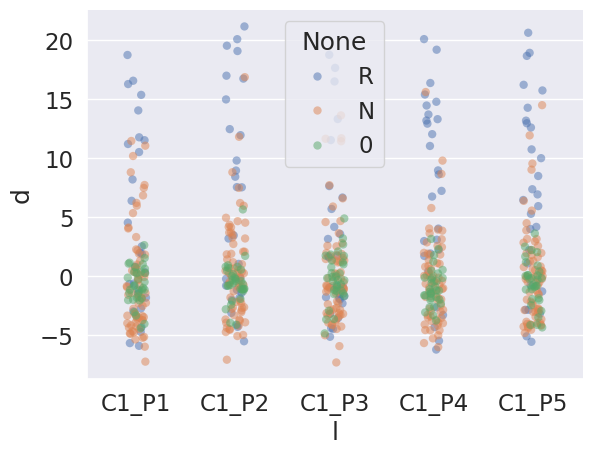

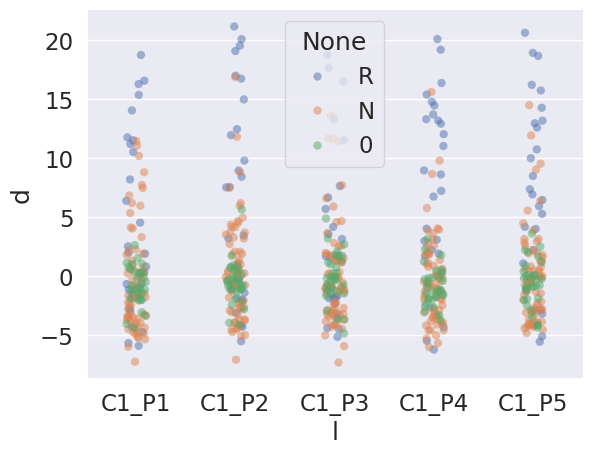

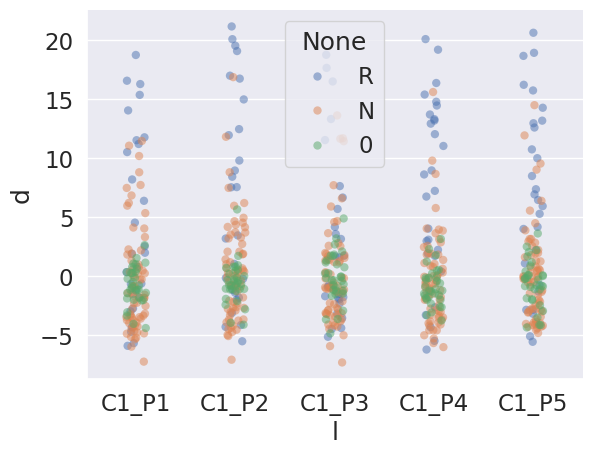

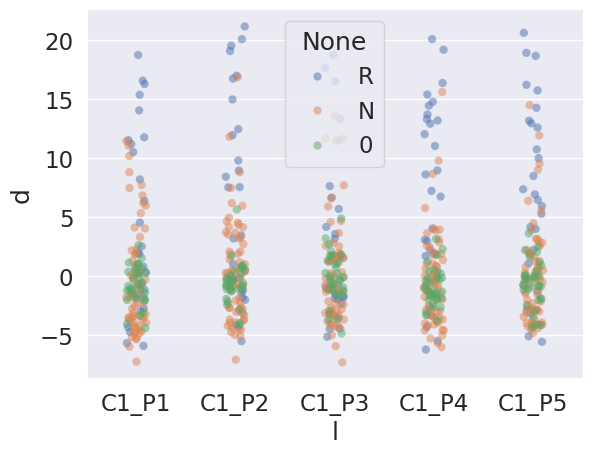

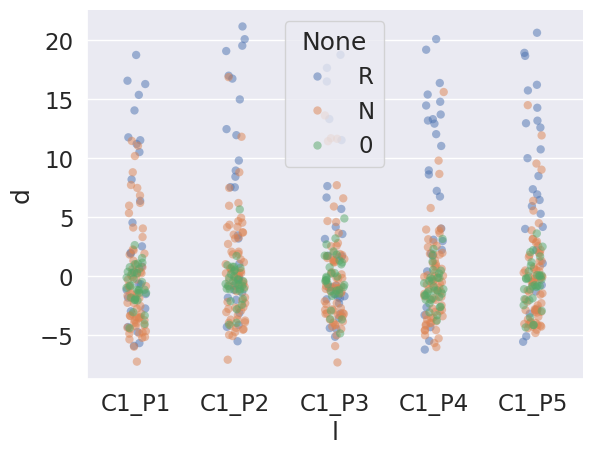

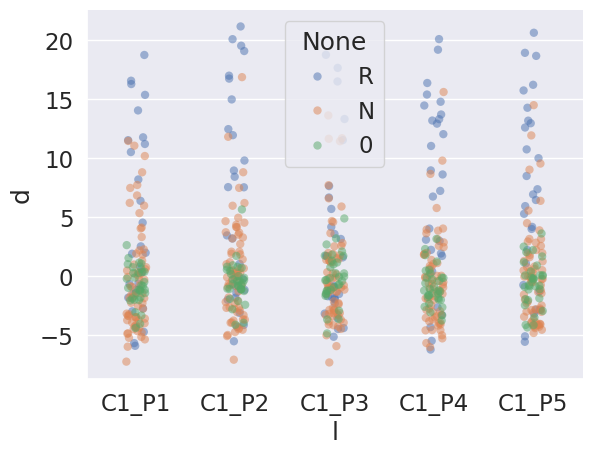

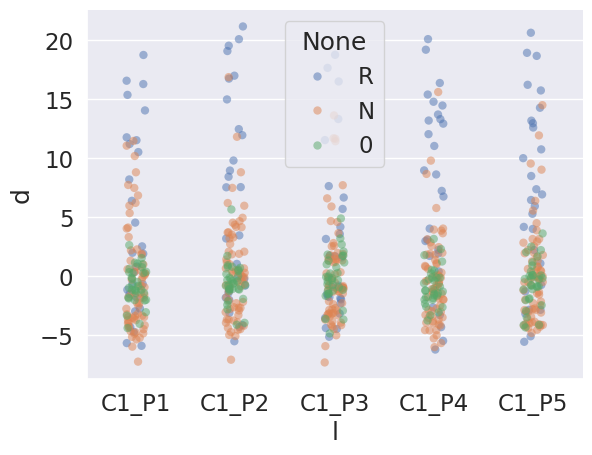

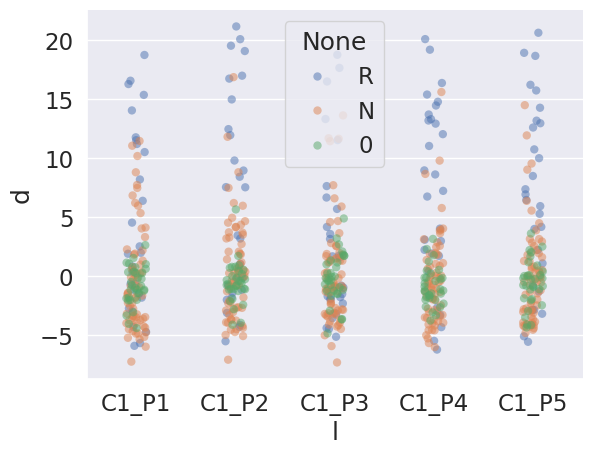

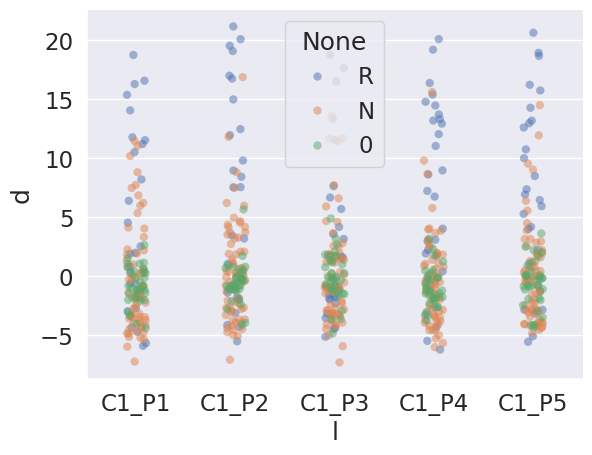

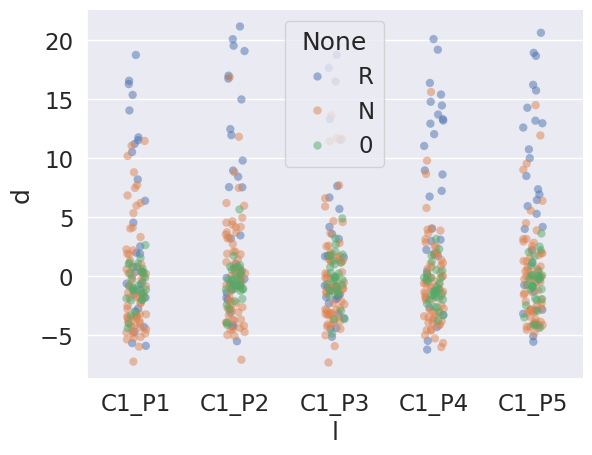

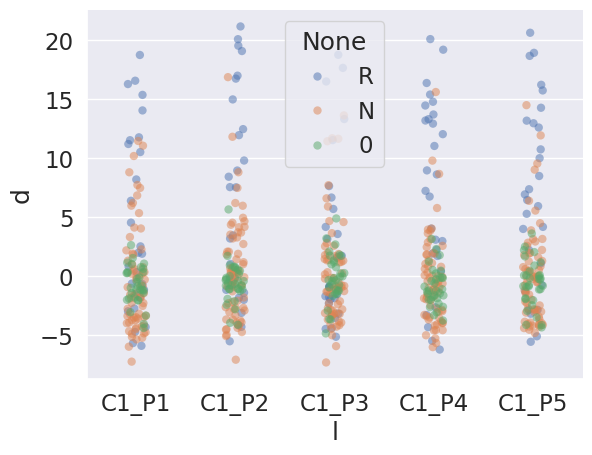

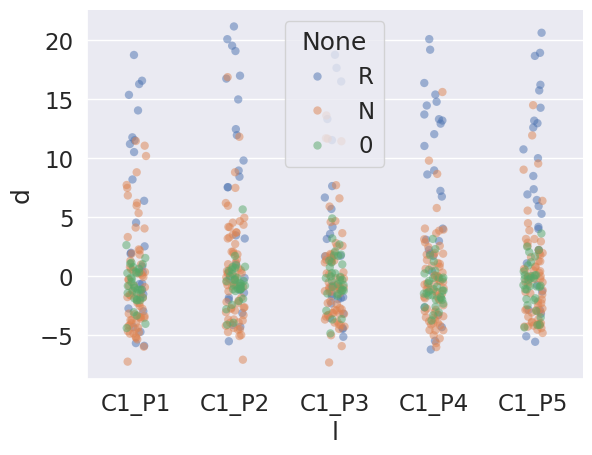

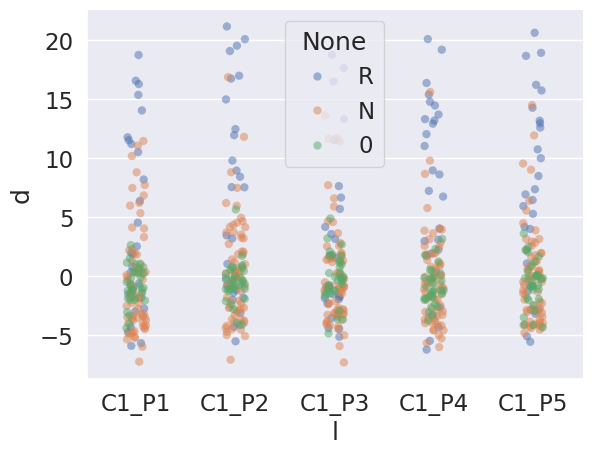

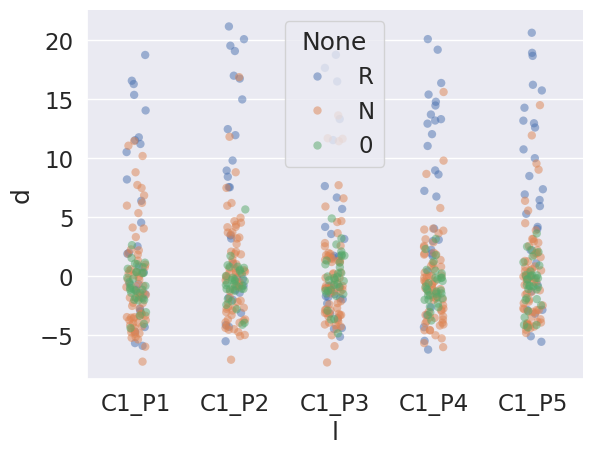

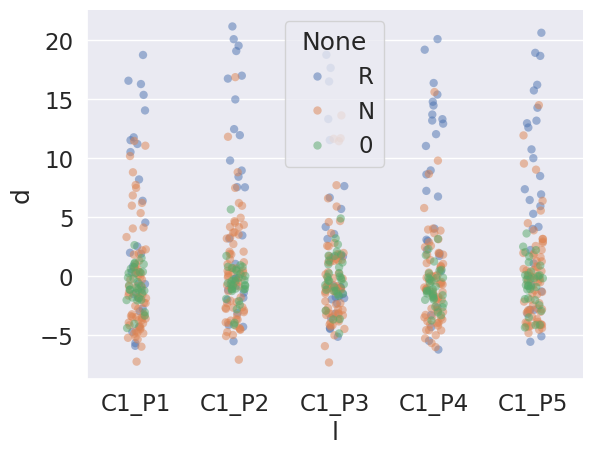

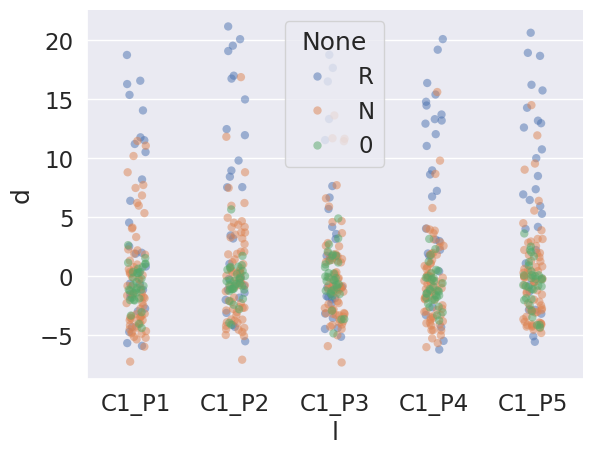

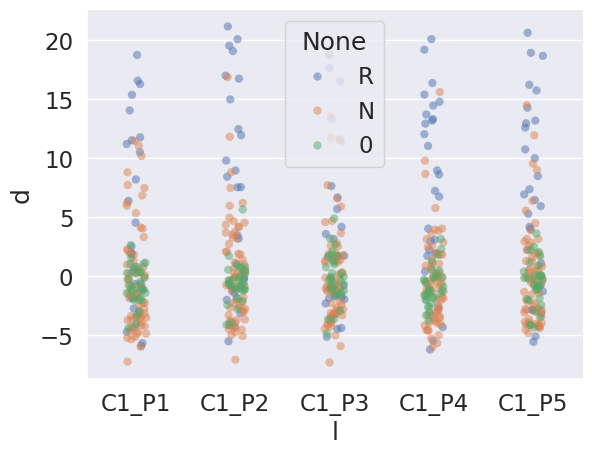

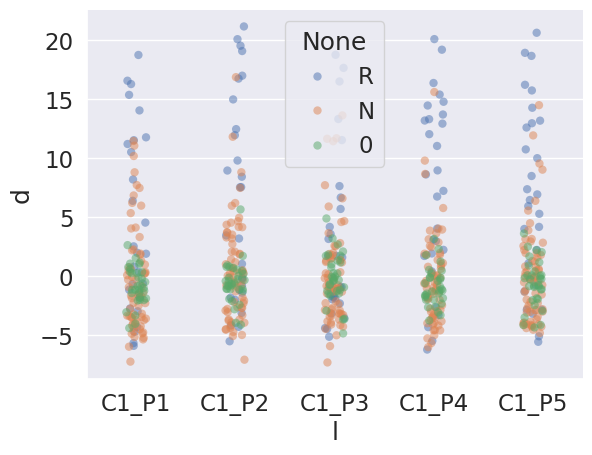

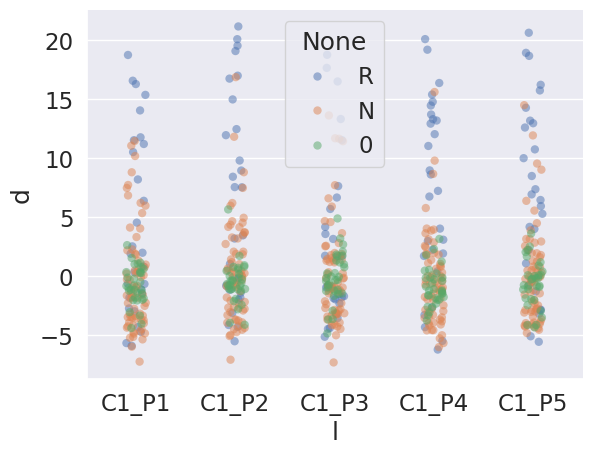

In [62]:
num_modules=24
for i in range(num_modules): 
    data_tog = []
    labels_tog = []
    for i, c in enumerate(dataset.T[:5]): 
        data_tog.append(c)
    data_tog=np.asarray(data_tog).flatten()
    labels_tog = np.asarray(labels[:5] * len(c))
    sample_names = np.asarray([[x]*5 for x in samp_meta.recurStatus.values]).flatten()
    df_tt = pd.DataFrame({"d" : data_tog, "l" : labels_tog}, index = sample_names)
    sns.stripplot(x = "l", y = "d", hue = df_tt.index, data = df_tt, 
                  edgecolor='none', alpha=0.5, jitter = True, size = 6)
    sns.despine()
    plt.show()

# My Own WGCNA

In [14]:
# stats
from scipy.stats import zscore, pearsonr
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cut_tree, fcluster # Import for tree cutting  
from dynamicTreeCut import cutreeHybrid # Dynamic Tree cutting package 
from scipy.spatial.distance import pdist

In [15]:
class networks(): 
    """
    A class for doing WGCNA type analysis on the arabidopsis dataset
    """
    def __init__(self, df, beta, thresh): 
        """
        Initialize the class

        Inputs:
         - df (pd.DataFrame) : a dataframe of samples on the rows and genes on the columns
         - beta (float) : a value to raise the network edges to to adjust connectivity 
         - thresh (float) : a value based on which to high filter pass the connectivities (0-1) 
        """
        self.data = df
        self.corr = df.corr().values
        self.beta = beta
        self.thresh = thresh # could be determined later through a function
        self.genes = df.columns 

    def __size__(self): 
        return self.corr.shape

    def power(self, beta): 
        return np.abs(self.corr)**beta

    def threshold(self, thresh):
        return np.asarray(self.corr > thresh, dtype='float')

    def forward(self, num_min=1):
        """
        Performing the forward function of the graph, which consists of three steps
        1. raising all correlation values to the power of beta
        2. thresholding based on the threshold value provided
        3. removing all nodes from the graph with connectvity of degree less than num_min

        Inputs: 
            - num_min (int) : the degree below which to remove nodes after thresholding
                (default = 1)
        """
        # self.corr = np.abs(self.corr)**self.beta
        
        self.corr = np.abs(self.corr)**self.beta # define power to be 10 (can iterate on this) 
        self.corr[self.corr < self.thresh] = 0
        
        # Determining which nodes to delete
        self.connectivity = np.asarray(self.corr > self.thresh, dtype='float')
        to_delete = np.where(self.connectivity.sum(axis=0) <= num_min)

        # deleting the determined nodes from the graph
        self.corr = np.delete(self.corr, to_delete, axis=0)
        self.corr = np.delete(self.corr, to_delete, axis=1)

    def connected_components(self): 
        return 0
        
    def cluster(self, dist_metric="euclidean", link_metric="average", min_clust_size=5):
        """
        For performing the clustering

        Inputs: 
            - dist_metric (string) : the distance metric to use for the HCA
            - link_metric (string) : the linkage metric over which to agglomerate the distances
            - min_clust_size (int) : the minimum number of nodes in a cluster for it to be considered valid. 

        Returns: 
            assignments : an array of per feature cluster assignment
            assignments_range : a numpy array of the valid clusters (passed the min threshold)
        """
        distances = pdist(self.corr, dist_metric)
        link = linkage(distances, link_metric)

        clusters = cutreeHybrid(link, distances)
        assignments = clusters["labels"]

        u, counts = np.unique(assignments, return_counts=True)
        assignments_range = u[np.where(counts >= 5)[0]]    
        return assignments, assignments_range

    def get_gene_clusters(self, assigments, a_range):
        # getting the indices for a given cluster assignment
        idx = {}
        for i in a_range:
            idx[i] = []
        for i, a in enumerate(assignments):
            if a in a_range:
                idx[a].append(i)

        # getting the names of those columns/genes
        inc_cols = {}
        for i in a_range:
            inc_cols[i] = self.genes[idx[i]]

        return inc_cols

    def calculate_eigenvectors(self, assignments, a_range, gene_clusts, min_clust_size=5, num_eigens=1): 
        """ 
        To calculate the eigenvectors of each cluster

        Note that if num_eigens > min_clust_size, than min_clust_size = num_eigens
        """ 
        if min_clust_size < num_eigens: 
            min_clust_size = num_eigens
        # for each identified module
        eigengenes = {}
        for i in a_range:
            # calculate the PCA fit to that cluster
            if (len(gene_clusts[i]) < min_clust_size): 
                continue
            self.pca = PCA().fit(self.data[gene_clusts[i]].corr().values)

            E = []
            for j in range(num_eigens):
                E.append(self.pca.components_[j])
        
            # get the Eigengene for the current module (based on the first timepoint)
            eigengenes[i] = E    
        
        return eigengenes 

In [26]:
def write_data(name, gene_clusts, eigens, beta):
    """
    Write out two pickle files, one for the gene clusters and one for the 
    Eigengene per cluster. 
    """
    with open(f"../data/r1/{name}_clusts_beta={beta}.pickle", "wb") as f:
        pickle.dump(gene_clusts, f)
    with open(f"../data/r1/{name}_eigens_beta={beta}.pickle", "wb") as f:
        pickle.dump(eigens, f)

(548, 548)
..cutHeight not given, setting it to 10.642116873789444  ===>  99% of the (truncated) height range in dendro.
..done.
0 9


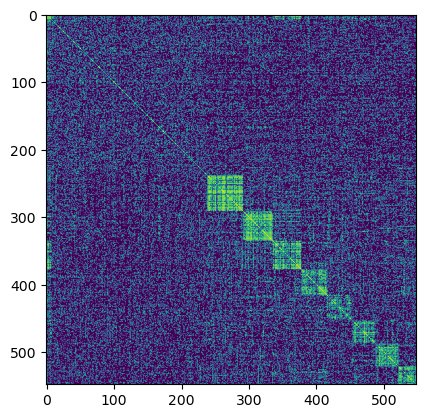

(229, 229)
..cutHeight not given, setting it to 4.286287022903202  ===>  99% of the (truncated) height range in dendro.
..done.
1 3


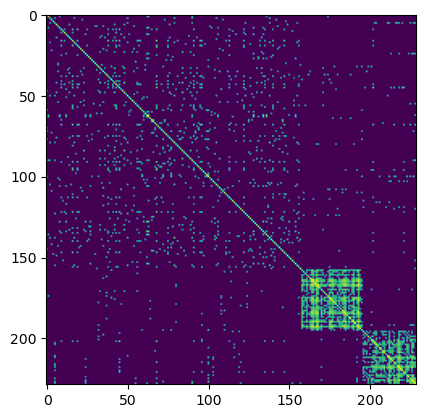

(59, 59)
..cutHeight not given, setting it to 3.443953465140073  ===>  99% of the (truncated) height range in dendro.
..done.
1 2


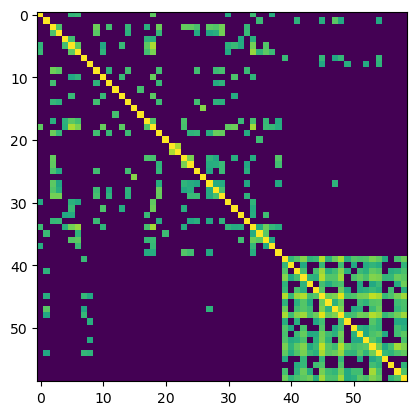

(27, 27)
..cutHeight not given, setting it to 2.934623711499163  ===>  99% of the (truncated) height range in dendro.
..done.
0 0


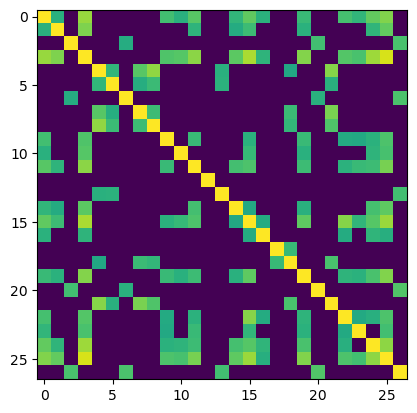

In [99]:
# %%capture
for b in [0.25, 0.5, 0.75, 1]:
    BETA = b
    THRESHOLD = 0.6
    w_graph = networks(gene_expression_subset, BETA, THRESHOLD)

    # Performing a clustering function
    w_graph.forward(num_min = 5)
    print(w_graph.__size__())
    assignments, a_range = w_graph.cluster()
    gene_clusts = w_graph.get_gene_clusters(assignments, a_range)
    print(min(assignments), max(assignments))
    eigens = w_graph.calculate_eigenvectors(assignments, a_range, gene_clusts, num_eigens=5)

    idx = np.argsort(assignments)
    temp = w_graph.corr
    temp = temp[idx]
    temp = temp.T[idx]
    
    fig = plt.imshow(temp)
    plt.show()

    write_data(f"wgc", gene_clusts, eigens, BETA)

## Analyze

### Bakground loadings stuff

In [113]:
def read_clust_file(filename): 
    """
    for Reading a clust file, and generating some additional statistics,
    such as: number of genes, number of clusters, size per cluster.
    Inputs: 
        - filename (filepath) : the pickled file to read
    Returns: tuple (number of genes, number of clusters, size per cluster, gene per cluster
    """
    fn = f'../data/{filename}'

    if not os.path.isfile(fn):
        print("ERROR: Non-existing file: ", fn)
        return 0

    with open(fn, 'rb') as f: 
        gc = pickle.load(f)

    num_clusts = len(gc) 
    cluster_sizes = [len(i) for i in gc.values()]
    num_genes = np.sum(cluster_sizes)
    
    return (num_genes, num_clusts, cluster_sizes, gc)

In [114]:
def read_eigen_file(filename): 
    """
    for Reading a eigen file, and returning it as a list of numpy arrays
    Inputs: 
        - filename (filepath) : the pickled file to read
    Returns: list of numpy arrays
    """
    fn = f'../data/{filename}'

    if not os.path.isfile(fn):
        print("ERROR: Non-existing file: ", fn)
        return 0

    with open(fn, 'rb') as f: 
        eg = pickle.load(f)
    
    return eg

In [109]:
clust_files = []
# eigen_files = []
betas = []
for file in os.listdir('../data/r1'): 
    if 'clusts' in file: 
        clust_files.append(file)
        betas.append(float(file.split('beta=')[1].split('.pickle')[0]))
        # vts.append(int(file.split('vt')[1].split('_clusts')[0]))


In [110]:
df = pd.DataFrame(clust_files, columns = ['file']).sort_index()

In [111]:
# Adding eigen files to the dataframe
eigen_files = []
for f in df.file: 
    eigen_files.append(f.replace('clusts', 'eigens'))
df['e_file'] = eigen_files

In [115]:
# getting a set of global genes 
set_genes = set(())
for f in df.file:
    (ng, nc, cs, gc) = read_clust_file(f'r1/{f}')
    for genes in gc.values(): 
        for g in genes:
            set_genes.add(g)
all_genes = np.asarray(list(set_genes))

In [118]:
def make_gene_vector(eigs, genes, all_genes): 
    vect = np.zeros(all_genes.shape[0])
    for i, g in enumerate(all_genes):
        if g in genes:
            idx = np.where(genes==g)[0][0]
            vect[i] = eigs[idx]
        else: 
            vect[i] = 0
    return vect

def cosine_similarity(vect1, vect2): 
    v1 = np.asarray(vect1) 
    v2 = np.asarray(vect2) 
    return np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2))

In [120]:
def add_eig(info, bb, cc, vv, pp):
    info['beta'].append(bb)
    info['clust'].append(cc)
    info['pc'].append(pp)
    info['vals'].append(vv)

In [128]:
betas = ['0.25', '0.5', '0.75', '1'] 

eigen_info = {
             'beta': [],
             'clust': [],
              'pc' : [],
             'vals':[]}
   
for b, row in zip(betas, df.iterrows()):
    fg1 = row[1]['file']
    fe1 = row[1]['e_file']
    (ng1, nc1, cs1, gc1) = read_clust_file(f'r1/{fg1}')
    eg1 = read_eigen_file(f'r1/{fe1}')
    
    for i, (eigens1, genes1) in enumerate(zip(eg1.values(), gc1.values())): 
        for j, pc in enumerate(eigens1): 
            vect1 = make_gene_vector(pc, genes1, all_genes)
            add_eig(eigen_info, b, i, vect1, j)

eigen_info['genes'] = all_genes

In [130]:
with open("../data/r1/eigen_info.pickle", "wb") as f: 
    pickle.dump(eigen_info, f)

### Actual stuff

#### correlation

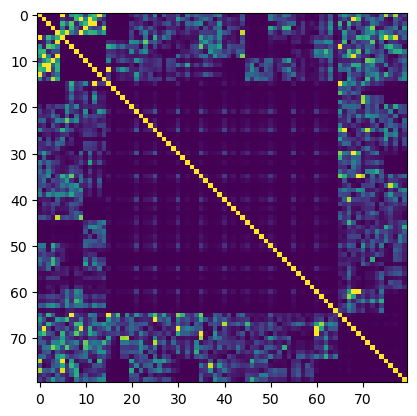

In [133]:
df_eigs = pd.DataFrame(eigen_info['vals'])
plt.imshow(np.abs(df_eigs.T.corr().values.T), vmin=0, vmax = 0.25)

### Projections

In [280]:
proj = gene_expression_subset @ np.asarray(eigen_info['vals']).T
labels = [f"{eigen_info['beta'][i]}_{eigen_info['clust'][i]}_{eigen_info['pc'][i]}" for i in range(len(eigen_info['beta']))]
df_dataset = pd.DataFrame(proj.values, columns = labels, index = gene_expression_subset.index)

In [283]:
with open("../data/prior_wgcnaAK_dataset.pandas", 'wb') as f: 
    pickle.dump(df_dataset, f)

#### Silly Factor Analysis

In [ ]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

In [172]:
chi_square_value, p_value = calculate_bartlett_sphericity(proj)
print(f'Chi-square value: {chi_square_value}\nP-value: {p_value}')

kmo_all, kmo_model = calculate_kmo(proj)
print(f'KMO Model: {kmo_model}')

Chi-square value: 7180.5714614674
P-value: 0.0
KMO Model: 0.32074595284364066


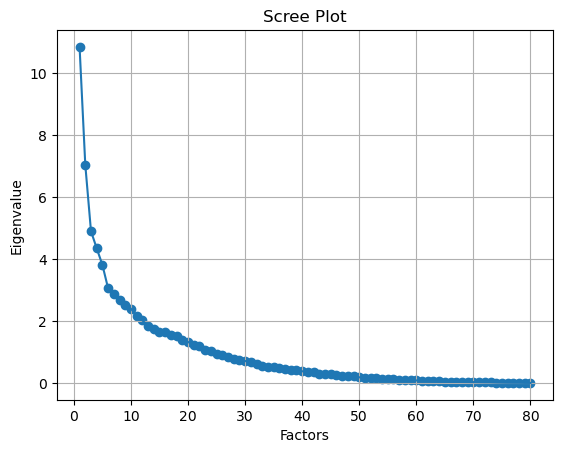

In [173]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(rotation="varimax")
fa.fit(proj)

# Check Eigenvalues
eigen_values, vectors = fa.get_eigenvalues()
plt.scatter(range(1, proj.shape[1]+1), eigen_values)
plt.plot(range(1, proj.shape[1]+1), eigen_values)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [159]:
# Perform factor analysis with the determined number of factors
fa = FactorAnalyzer(n_factors=6, rotation="varimax")
fa.fit(proj)

# Get factor loadings
loadings = fa.loadings_
print(loadings.shape)

# Get variance of each factor
fa.get_factor_variance()

# Get factor scores
factor_scores = fa.transform(proj)
# print(factor_scores)

(80, 6)


In [161]:
pd.DataFrame(factor_scores)

0         1         2         3         4         5
0  -0.196901  0.648174 -0.461666  0.961966  1.217450 -0.790543
1   0.721506 -0.762843 -0.936180  0.696128  0.834883  0.729528
2   1.147223 -0.239700  0.548539  0.769376  0.534632 -1.370053
3  -0.458245 -0.728716  0.401382 -0.121962 -0.564612  0.697530
4  -0.343598  0.060128  0.935367 -0.052042  0.807337 -0.146638
..       ...       ...       ...       ...       ...       ...
91  3.871397  0.870885  4.305023 -2.859318 -2.022771  0.408727
92 -0.511096  0.026623  0.244192  0.519219 -0.224863  0.642526
93 -0.139058 -0.055260 -0.997350  0.006713 -0.143421 -0.071642
94 -0.210798 -0.644280  1.118576  0.433857 -1.313541 -0.847628
95 -0.726369  0.217705  1.739697  0.689039 -0.162907  0.070032

[96 rows x 6 columns]

#### Linear Separability Analysis

In [169]:
from sklearn.linear_model import LinearRegression, LogisticRegression

In [184]:
samp_meta

Age  Gender cancertype  cancerstage_cat  chemo_duration  \
Sample name                                                                  
C1           34.443836  Female     Ductal              3.0            98.0   
C2           43.353425  Female     Ductal              3.0            98.0   
C3           43.852055  Female     Ductal              2.0           133.0   
C4           41.421918  Female     Ductal              2.0           133.0   
C5           42.115068  Female     Ductal              3.0           105.0   
...                ...     ...        ...              ...             ...   
C92          40.767123  Female     Ductal              2.0            63.0   
C93          43.443836  Female     Ductal              2.0           111.0   
C94          43.904110  Female     Ductal              2.0           111.0   
C95          39.454795  Female     Ductal              3.0            98.0   
C96          39.767123  Female     Ductal              3.0            98.0   

             recurrence_time chemo recurStatus  
Sample name                                     
C1                      82.0  AC/T           R  
C2                      82.0  AC/T           R  
C3                     538.0  AC/T           R  
C4                     538.0  AC/T           R  
C5                     604.0  AC/T           R  
...                      ...   ...         ...  
C92                      0.0    TC           N  
C93                      0.0  AC/T           N  
C94                      0.0  AC/T           N  
C95                      0.0  AC/T           N  
C96                      0.0  AC/T           N  

[96 rows x 8 columns]

Age


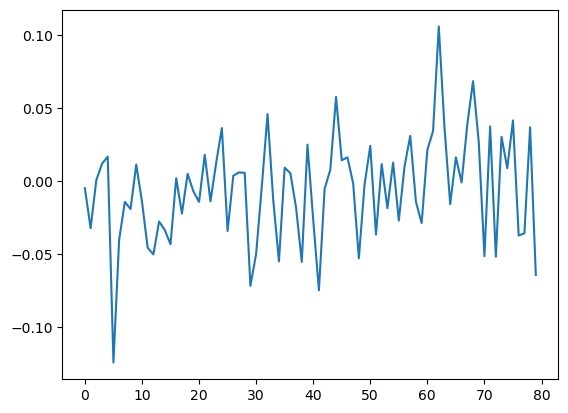

cancertype


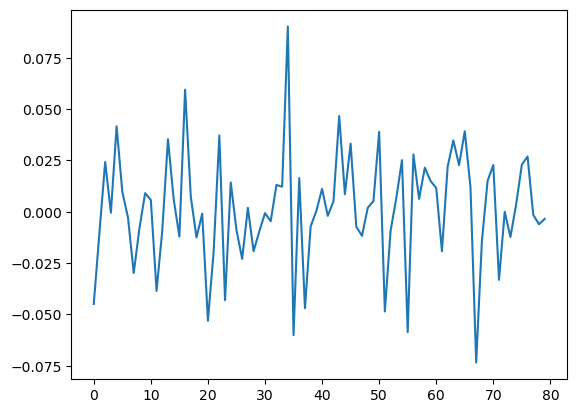

cancerstage_cat


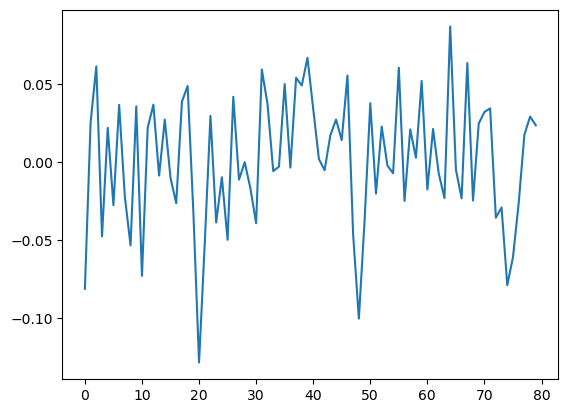

chemo_duration


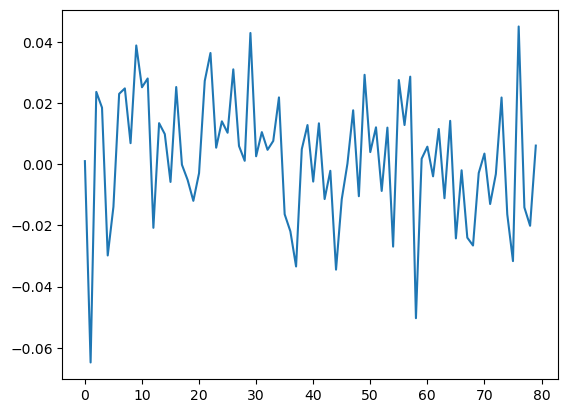

recurrence_time


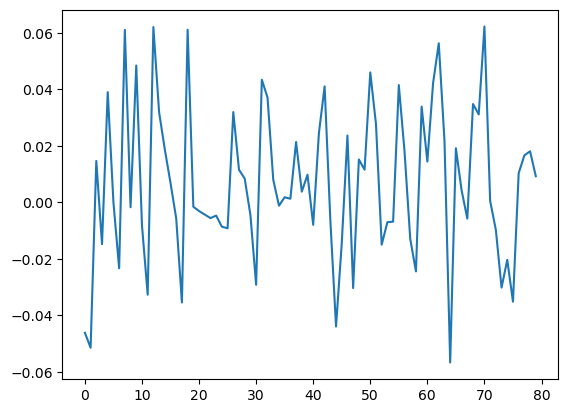

chemo


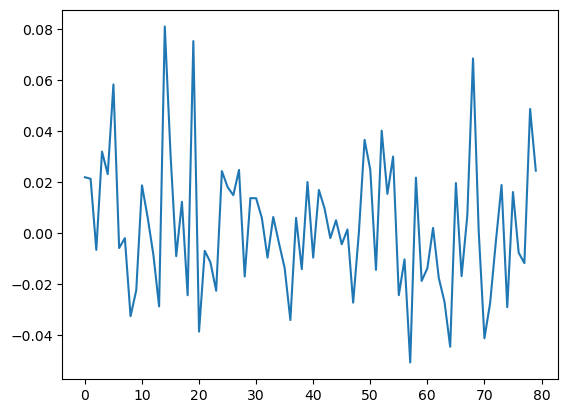

recurStatus


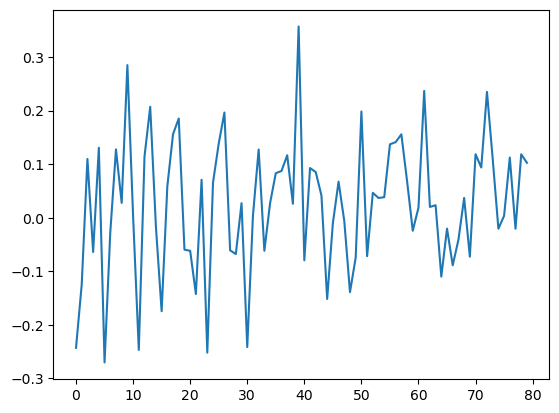

In [195]:
cat = ['Gender', 'cancertype', 'cancerstage_cat', 'chemo', 'recurStatus']
weights_all = []
for c in samp_meta.columns:
    if c == "Gender":
        continue
    print(c)
    y = samp_meta[c].values
    if c in cat: 
        clf = LogisticRegression(max_iter = 1000).fit(proj.values, y)
        weights = clf.coef_[0]
    else: 
        y = zscore(y)
        clf = LinearRegression().fit(proj.values, y)
        weights = clf.coef_

    weights_all.append(weights)
    plt.plot(weights)
    plt.show()
    
    # break

In [199]:
weights_all = np.asarray(weights_all)

In [214]:
where_max = weights_all.argmax(axis=0)
interm_types = samp_meta.columns.drop('Gender')
keep_cluster = (interm_types[where_max] == "recurStatus")

array(['0.25_0_2', '0.25_0_4', '0.5_0_2', '0.5_0_3', '0.5_0_4', '0.5_1_2',
       '0.5_1_3', '0.75_0_2', '0.75_0_3', '0.75_1_2', '0.75_1_4',
       '0.75_2_0', '0.75_2_1', '0.75_3_2', '0.75_4_0', '0.75_4_1',
       '0.75_4_2', '0.75_4_4', '0.75_5_1', '0.75_5_2', '0.75_6_1',
       '0.75_7_0', '0.75_7_2', '0.75_7_3', '0.75_7_4', '0.75_8_0',
       '0.75_8_1', '0.75_8_2', '0.75_8_3', '0.75_9_1', '1_1_0', '1_1_1',
       '1_1_2', '1_1_3', '1_2_1', '1_2_3', '1_2_4'], dtype='<U8')

In [249]:
proj_update = gene_expression_subset.values @ np.asarray(eigen_info['vals'])[keep_cluster].T

In [250]:
df_dataset = pd.DataFrame(proj_update, columns = np.asarray(labels)[keep_cluster], index = gene_expression_subset.index)

In [253]:
with open("../data/prior_wgcnaAK_mod_dataset.pandas", 'wb') as f: 
    pickle.dump(df_dataset, f)

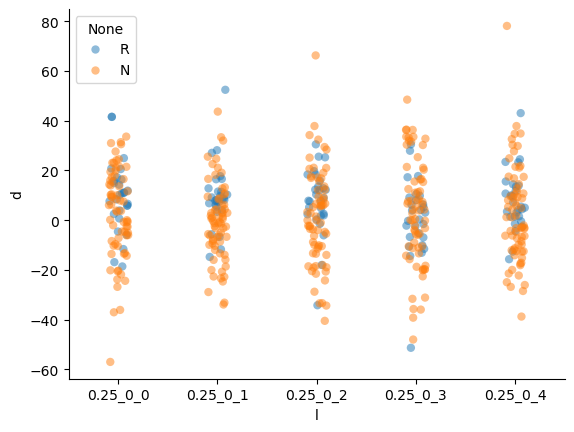

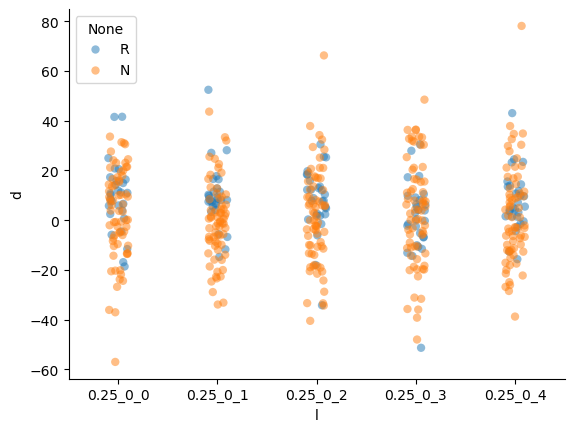

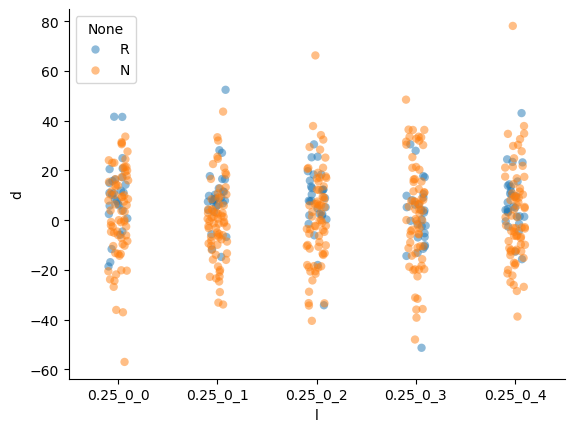

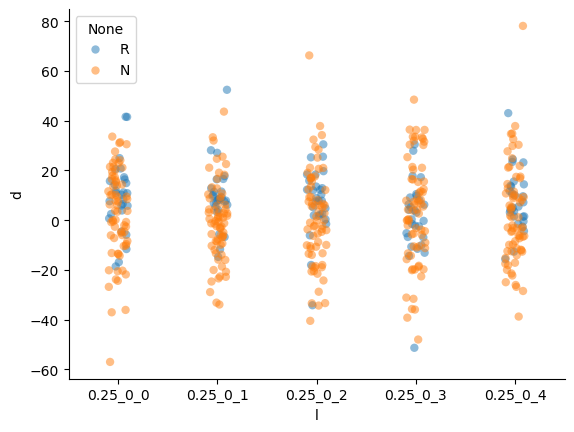

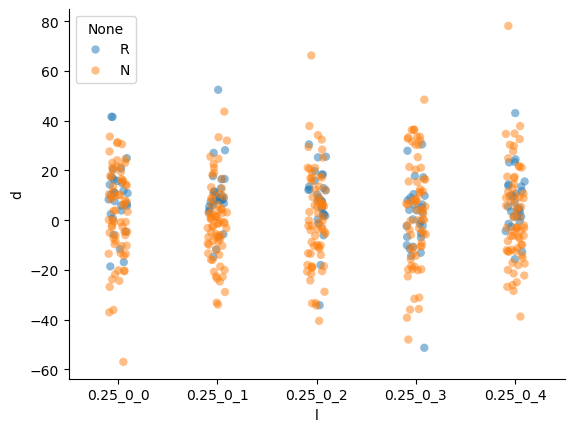

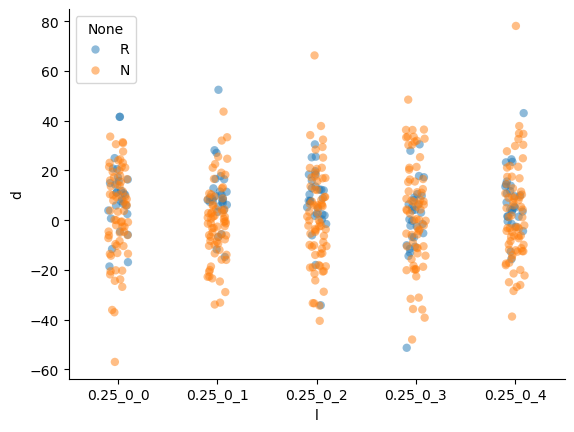

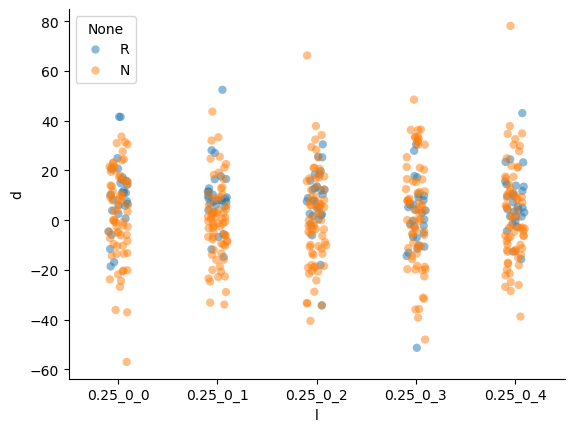

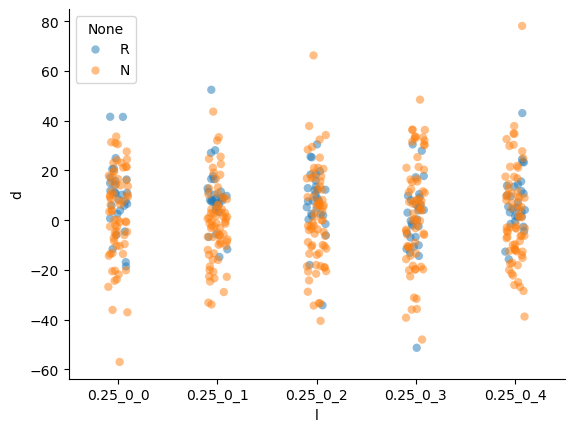

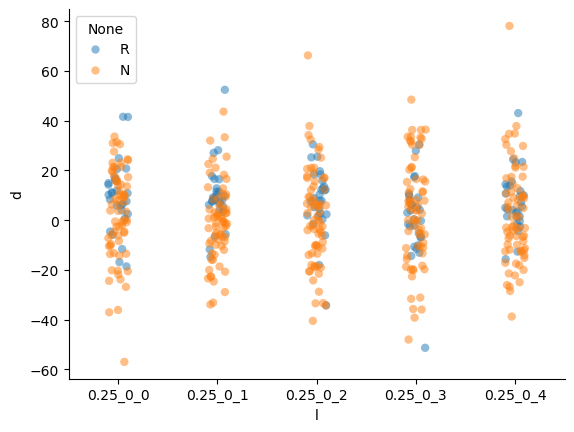

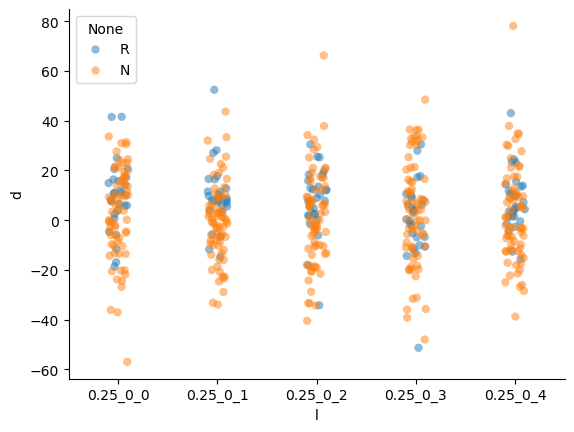

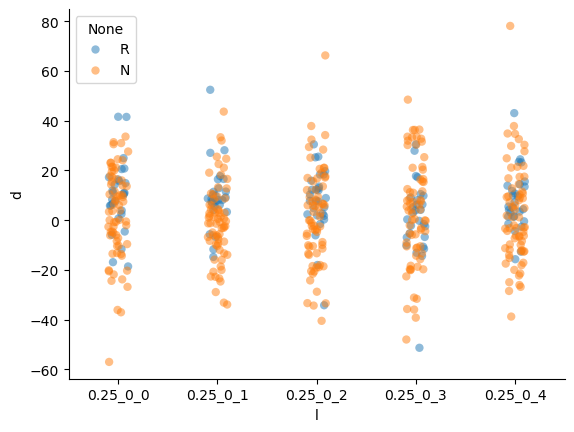

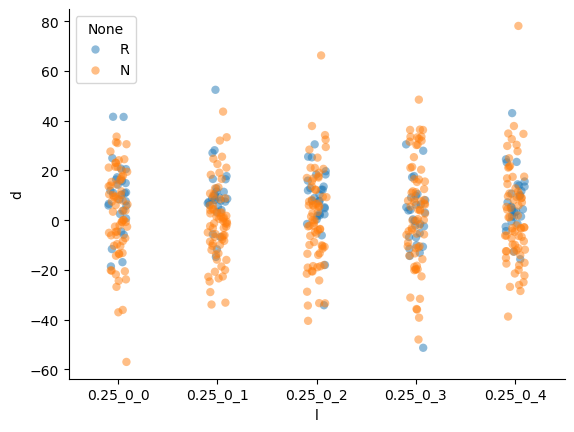

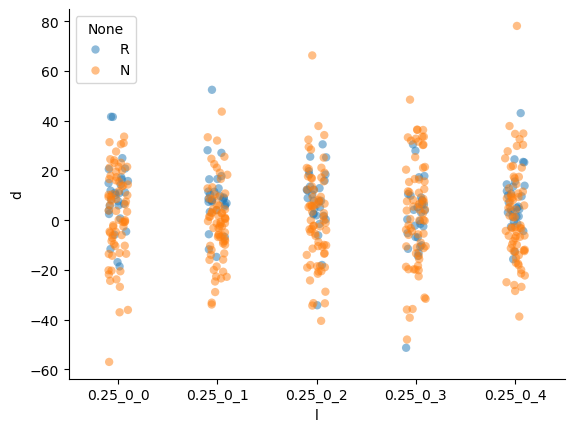

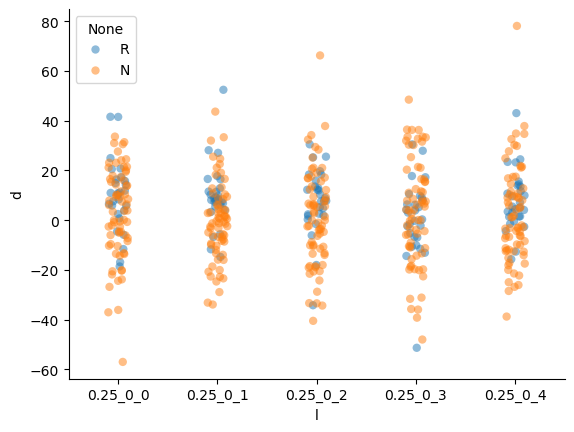

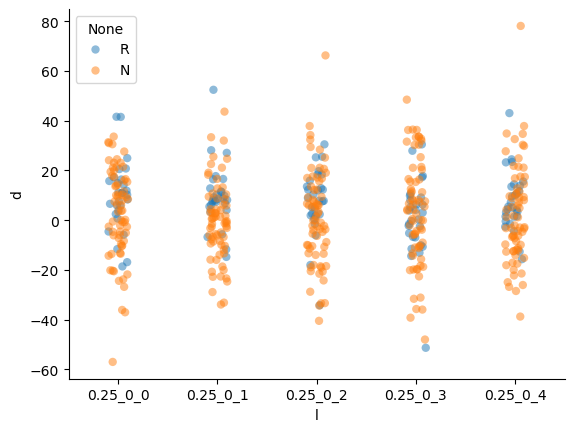

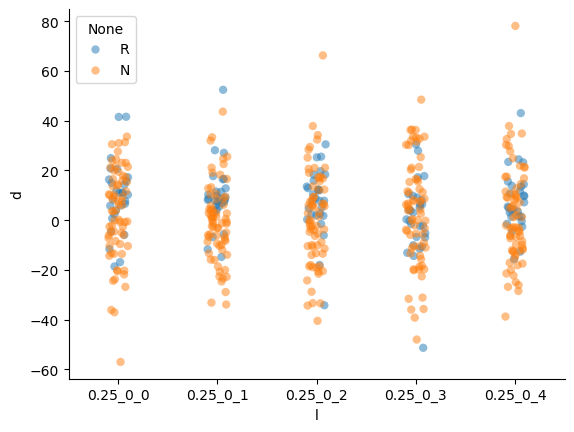

In [276]:
num_modules= int(80 / 5)
for i in range(num_modules): 
    data_tog = []
    labels_tog = []
    for i, c in enumerate(proj.values.T[:5]): 
        data_tog.append(c)
    data_tog=np.asarray(data_tog).flatten()
    labels_tog = np.asarray(labels[:5] * len(c))
    sample_names = np.asarray([[x]*5 for x in samp_meta.recurStatus.values]).flatten()
    df_tt = pd.DataFrame({"d" : data_tog, "l" : labels_tog}, index = sample_names)
    sns.stripplot(x = "l", y = "d", hue = df_tt.index, data = df_tt, 
                  edgecolor='none', alpha=0.5, jitter = True, size = 6)
    sns.despine()
    plt.show()